<a href="https://colab.research.google.com/github/coregvy/Con4AI/blob/master/handson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# コネクトフォー の ゲームAIを作ろう

## AI環境の準備

### tensorflow 1.x インストール
tensorflow 1系はColabで使えなくなったので、強制的にインストールする\
参考：https://qiita.com/katoyu_try1/items/0228870c41d9ac54e6e9

将来的には Stable Baselines3に対応するよう改修予定

In [ ]:
!apt-get update && apt-get install -y -q cmake libopenmpi-dev zlib1g-dev

In [ ]:
!apt-get install -y -q ffmpeg freeglut3-dev xvfb

In [ ]:
!pip install tensorflow-gpu==1.15.2 --quiet

### ライブラリのインストール

MPIは並列処理のライブラリです。

In [ ]:
#!python3.7
!pip install gym==0.19.0 stable-baselines==2.10.2 --quiet
# !pip install stable-baselines[mpi] --quiet

### Dependencis

In [ ]:
#!python3.7
import tensorflow as tf;
import re
import random
import numpy as np

import gym
# from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2

import warnings

# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

+ tensorflow のインストール確認

In [ ]:
import tensorflow as tf;
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

## 簡単なゲームでAIを学ぶ

上下左右に移動して、ゴールを目指すゲームという簡単なルールのゲームを通して、[StableBaselines](https://stable-baselines.readthedocs.io/en/master/index.html) / [OpenAI Gym](https://github.com/openai/gym) を使ったゲームAIの作り方を学んでいきます。

### ゲームルール

以下のような入力を与えます
```
.......
.......
..P....
.......
.......
.....G.
.......
```
7x7マスに `P` (Player) の位置から `G` (Goal) に向けて移動するゲームです。
出力には

- 0: 上
- 1: 右
- 2: 下
- 3: 左

に移動します。枠外に出てしまった場合は失敗です。


### 環境クラス

ゲームのルールにあわせた、環境クラスを作成します。\
環境クラスでは以下のメソッドを定義する必要があります。
* reset：状態を初期化します
* step：次の行動を入力として、一つステップを進める関数を作成します。報酬の計算も行います。
* render：現在の状態を描画します。中身は適当で大丈夫です

また、以下の変数をコンストラクタで定義する必要があります。
* action_space：実際の行動の数を設定
* self.observation_space：状態空間の定義


In [ ]:
class Dist(gym.Env):
  MAX_X = 7
  MAX_Y = 7
  ACTION_TOP = 0
  ACTION_RIGHT = 1
  ACTION_BOTTOM = 2
  ACTION_LEFT = 3
  PRE = [0,0,0]
  ACTION_MARK = ['↑','→','↓','←']
  POS_MY = [0,0]
  POS_GOAL = [MAX_X, MAX_Y]

  def __init__(self) -> None:
    super(Dist, self).__init__()
    self.initState()
    self.action_space = gym.spaces.Discrete(4)
    self.observation_space = gym.spaces.Box(low=0, high=self.MAX_X * self.MAX_Y - 1, shape=(5,), dtype = np.uint8)

  def reset(self):
    # 状態を初期化します
    self.initState()
    return self.state()

  def step(self, action):
    self.PRE = [self.POS_MY[0], self.POS_MY[1], action]
    # 座標移動
    if action == self.ACTION_TOP:
      self.POS_MY[1] -= 1
    elif action == self.ACTION_RIGHT:
      self.POS_MY[0] += 1
    elif action == self.ACTION_BOTTOM:
      self.POS_MY[1] += 1
    elif action == self.ACTION_LEFT:
      self.POS_MY[0] -= 1
    
    # ゴールまでの距離を計算
    dist = self.distance(self.POS_MY, self.POS_GOAL)
    # ゴールしたか、枠外に出た場合は終了
    done = (dist == 0) or self.isOver()
    reward = 0
    if dist == 0:
      reward = 1
    return self.state(), reward, done, {}

  # 現在の盤面の状態をコンソール表示
  def render(self, mode='console', close=False):
    print(str(self.state()))
    for y in range(self.MAX_Y):
      print('| ', end='')
      for x in range(self.MAX_X):
        print(self.renderMark(x, y), end='')
      print(' |')

  def renderMark(self, x, y):
    if (x == self.POS_MY[0]) and (y == self.POS_MY[1]):
      return 'P'
    elif (x == self.POS_GOAL[0]) and (y == self.POS_GOAL[1]):
      return 'G'
    elif (x == self.PRE[0]) and (y == self.PRE[1]):
      return self.ACTION_MARK[self.PRE[2]]
    else:
      return '.'
  
  # ゲームをリセットする(P/G の位置をランダムに配置)
  def initState(self):
    self.POS_MY = [random.randrange(self.MAX_X - 1), random.randrange(self.MAX_Y - 1)]
    self.POS_GOAL = [random.randrange(self.MAX_X - 1), random.randrange(self.MAX_Y - 1)]
    # ゴールまで近すぎる場合はやり直し
    if self.distance(self.POS_MY, self.POS_GOAL) < 3:
      self.initState()

  # 枠外に出たかどうかを判定
  def isOver(self):
    if self.POS_MY[0] < 0 or self.POS_MY[1] < 0 or self.POS_MY[0] >= self.MAX_X or self.POS_MY[1] >= self.MAX_Y:
      return True
    return False 

  def state(self):
    return [self.POS_MY[0], self.POS_MY[1], self.POS_GOAL[0], self.POS_GOAL[1], self.distance(self.POS_MY, self.POS_GOAL)]

  # マンハッタン距離を返す
  def distance(self, a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


### トレーニングしてみる

上で作った環境クラスを使って、実際にトレーニングしてみます。

In [ ]:
env0 = Dist()

# モデルの生成
#  verbose：ログの詳細表示(0:ログなし、1:訓練情報を表示、2:TensorFlowログを表示)
model0 = PPO2('MlpPolicy', env0, verbose=0, tensorboard_log="./log/step0")

# モデルの学習回数
sample = 10000
model0.learn(total_timesteps=sample)
# モデルをファイル保存
model0.save('dist_model_' + str(sample))

print('training end')


### 学習結果を確認してみましょう

まずはグラフで学習結果を確認してみましょう。

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./log/

次に、作ったAIが想定通りに動くか実際に試してみましょう

In [ ]:
# 状態をリセット
env0.reset()
i = 0
while True:
  i += 1
  # 次のAIの行動を取得する
  action, _ = model0.predict(env0.state())
  state, reward, done, info = env0.step(action)
  # 現在の状態を描画
  env0.render()

  if done:
    print('end: ', i)
    break
  print('next action:', done, action, reward)


うまくゴールまで行けたでしょうか？\
次は、より最適な行動をAIが選択するように、どうやって改良するかを学びます。

## AIのチューニング

### 報酬とは？

機械学習では、教師データ（入力とそれに対する正しい答え）の代わりに、入力に対する報酬を評価するロジックを作成します。

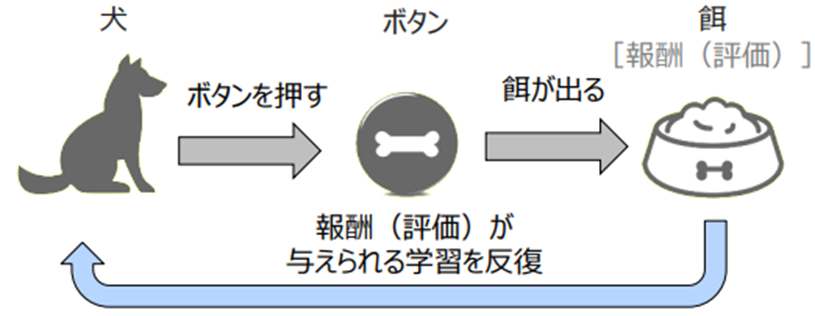

環境クラスの step 関数をみてみます。

```python
  def step(self, action):
    self.PRE = [self.POS_MY[0], self.POS_MY[1], action]
    # 座標移動
    if action == self.ACTION_TOP:
      self.POS_MY[1] -= 1
    elif action == self.ACTION_RIGHT:
      self.POS_MY[0] += 1
    elif action == self.ACTION_BOTTOM:
      self.POS_MY[1] += 1
    elif action == self.ACTION_LEFT:
      self.POS_MY[0] -= 1
    
    # ゴールまでの距離を計算
    dist = self.distance(self.POS_MY, self.POS_GOAL)
    done = (dist == 0) or self.isOver()
    reward = 0
    if dist == 0:
      reward = 1
    return self.state(), reward, done, {}
```

action(次の行動) を与えて、現在の状態を更新し、reward(報酬) を返却しています。
機械学習は、この報酬が大きくなる行動を選んでいます。

上のコードでは、ゴールした時のみ報酬を与えていますが、この場合、どれだけ遠回りしてもゴールさえできれば報酬の合計は変わらないです。\
遠回りしないAIを作るには、ゴールに近づいたときに報酬を与えたり、遠回りした時に報酬を減らしたりしなければいけません。

```python
  def step(self, action):
    self.PRE = [self.POS_MY[0], self.POS_MY[1], action]
    beforeDist = self.distance(self.POS_MY, self.POS_GOAL)
    if action == self.ACTION_TOP:
      self.POS_MY[1] -= 1
    elif action == self.ACTION_RIGHT:
      self.POS_MY[0] += 1
    elif action == self.ACTION_BOTTOM:
      self.POS_MY[1] += 1
    elif action == self.ACTION_LEFT:
      self.POS_MY[0] -= 1
    
    dist = self.distance(self.POS_MY, self.POS_GOAL)
    done = (dist == 0) or self.isOver()
    reward = 0
    if dist == 0:
      # ゴールした
      reward = 1
    elif dist > beforeDist:
      # ゴールから遠ざかった
      reward = -0.1
    return self.state(), reward, done, {}
```

上のように変更して実行してみましょう。\
最短でゴールすれば、報酬は `1`、遠回りした回数が多いほど報酬が減らされることになります。\
tensorboard のグラフを確認して、どのような変化があったか確認してみましょう。

今回の移動ゲームはルールが単純ですが、複雑になるほど報酬の与え方を調整しなければいけません。


### 学習回数とは？

先ほどの例では、サンプル数を１万回でトレーニングしました。

```python
# モデルの学習回数
sample = 10000
model0.learn(total_timesteps=sample)
model0.save('dist_model_' + str(sample))
```

こちらの数を変更して、もう一度実行してみてください。

今回は単純なゲームなので、あまり変化が見られないかもしれませんが、基本的には学習回数を増やせばその分より良い行動をとるAIになります。\
しかし学習回数が多くなると、特定のパターン（攻略法）だけを学習してしまい、全体のパターンをつかめなくなる ”過学習” という現象が発生しやすくなります。

学習の様子を tensorboard のグラフで確認したり、実際に動かしてみながら、最適な学習回数を探す必要があります。



### その他の機械学習AIチューニング方法

今回はトレーニングの際に、機械学習アルゴリズムとして、["PPO2"](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) というアルゴリズムと、["MlpPolicy"](https://stable-baselines.readthedocs.io/en/master/modules/policies.html) を使っています。

```python
model0 = PPO2('MlpPolicy', env0, verbose=0, tensorboard_log="../log/step0")
```

これらが具体的にどんなものかは、各自で調べてみてください。
内容は非常に難しいですが、攻略がうまくいかない場合はアルゴリズムから変更してみるのもいいかもしれません。

パラメータもデフォルト値を使いましたが、今回のゲームでは、例えば１回ごとの行動でゴールに近づいた場合に報酬を与えたり、離れた場合にマイナスの報酬を与えるようなstep関数を作ったとしましょう。
その場合、シナリオ全体の報酬ではなく、1回の行動ごとに高い報酬を得るように行動するAIを作りたいです。\
そんな時には、割引率(gamma)を小さな値にしたり、学習率(lerning_rate)を小さくしたほうがよいかもしれません。

```python
model0 = PPO2('MlpPolicy', env0, gamma=0.6, lerning_rate=0.01, verbose=0, tensorboard_log="../log/step0_2")
```

逆に、１回のゲーム全体でみてより大きい報酬を得たい場合は、それらの値を大きくすると、AIの行動が変わってきます。\
報酬の与え方次第では、遠回りしてゴールまでの移動回数を大きくしたほうが、シナリオごとの総報酬が大きくなってしまい、いつまでもゴールしないAIができてしまうかもしれません。

アルゴリズムごとに他にもたくさんのパラメータがありますので、調べてみるとより強いAIができるかもしれません。\
パラメータを調整するのと合わせて、学習結果のグラフを読み取る力もつけていく必要があります。


### Challenge!

ゲームの盤面に障害物（プレイヤーが移動できないマス）を置いた時、正しくゴールまで移動できるAIを作ってみましょう！\
難しい場合は [こちら](https://ailog.site/2021/05/23/2021/0523/) を参考にしてみましょう。

## コネクトフォーのAIを作る

いよいよコネクトフォーのAIを作ってみましょう。

### game_util.py

コネクトフォー独自のルールやロジックなど

In [ ]:
import re
import random

class GameUtil:
  @staticmethod
  def stdinToState(stdin, blank='0', my='1', your='2'):
    # サーバから受け取る盤面の情報を読み込む
    ao = stdin.splitlines()
    meta = ao.pop(0).split(' ')
    return list(map(lambda x: list(re.sub('[^MB]', 'Y', x.replace('.', 'B').replace(meta[2], 'M')).replace('Y', your).replace('B', blank).replace('M', my)), ao))

  def listToState(ao, meta, blank='0', my='1', your='2'):
    # 一次元配列で受け取った盤面の情報を二次元配列に置き換える
    for row in range(int(meta[1])):
      for col in range(int(meta[0])):
        if ao[row][col] == '.':
          ao[row][col] = blank
        elif ao[row][col] == meta[2]:
          ao[row][col] = my
        else:
          ao[row][col] = your
    return ao

  @staticmethod
  def resetState(row = 6, col = 7):
    return [['0'] * col for i in range(row)]

  @staticmethod
  def fallCoin(state, action, mark='1', blank='0'):
    """ Return new state

    Args:
        state (list[list[str]]): state list
        action (number): [colmn number]
        mark (str, optional): [description]. Defaults to '1'.
        blank (str, optional): [description]. Defaults to '0'.

    Returns:
        list: new state
    """
    fallNg = True
    for ry in range(len(state)):
      y = len(state) - ry - 1
      if state[y][action] == blank:
        state[y][action] = mark
        fallNg = False
        break
    return state, fallNg

  @staticmethod
  def checkEnd(state, goal=4, blank='0'):
    """ Check if the game is finished

    Args:
        state (list[list[str]]): game state list
        goal (int, optional): goal count. Defaults to 4.
        blank (str, optional): blank mark. Defaults to '0'.

    Returns:
        str: Win mark or blank
    """
    # GameUtil.render(state)
    # check row(-)
    for row in range(len(state)):
      for col in range(len(state[row]) - goal + 1):
        tmpMark = state[row][col]
        if tmpMark == blank:
          continue
        for p in range(goal - 1):
          if tmpMark != state[row][col + p + 1]:
            tmpMark = blank
            break
        
        if tmpMark != blank:
          return tmpMark

    # check col(|)
    for col in range(len(state[0])):
      for row in range(len(state) - goal + 1):
        tmpMark = state[row][col]
        if tmpMark == blank:
          continue
        for p in range(goal - 1):
          if tmpMark != state[row + p + 1][col]:
            tmpMark = blank
            break

        if tmpMark != blank:
          return tmpMark

    # check /
    for row in range(goal - 1, len(state)):
      for col in range(0, len(state[row]) - goal + 1):
        tmp = state[row][col]
        if tmp == blank:
          continue
        for r in range(1, goal):
          if tmp != state[row - r][col + r]:
            tmp = blank
            break
        if tmp != blank:
          return tmp

    # check \
    for row in range(len(state) - goal + 1):
      for col in range(len(state[row]) - goal + 1):
        tmp = state[row][col]
        if tmp == blank:
          continue
        for r in range(1, goal):
          if tmp != state[row + r][col + r]:
            tmp = blank
            break
        if tmp != blank:
          return tmp

    return blank

  @staticmethod
  def checkReach(state, mark = '1', goal=4, blank='0'):
    """ Check if the game is Reach

    Args:
        state (list[list[str]]): game state list
        goal (int, optional): goal count. Defaults to 4.
        blank (str, optional): blank mark. Defaults to '0'.

    Returns:
        str: Win mark or blank
        pos: reach column
    """
    ret = []
    for i in range(len(state[0])):
      ps, _ = GameUtil.fallCoin(GameUtil.stateCopy(state), i, mark, blank)
      ec = GameUtil.checkEnd(ps, goal, blank)
      if ec != blank:
        ret.append([ec, i])
    return ret

  @staticmethod
  def stateCopy(state):
    row = len(state)
    col = len(state[0])
    ret = [['0'] * col for i in range(row)]
    for r in range(row):
      for c in range(col):
        ret[r][c] = state[r][c]
    return ret


  @staticmethod
  def render(state, my = '1', blank = '0'):
    print('-0-1-2-3-4-5-6-')
    for i in range(len(state)):
      print(' ', end='')
      for j in range(len(state[i])):
        mark = '☆'
        if state[i][j] == my:
          mark = '◆'
        elif state[i][j] == blank:
          mark = '・'
        print(mark, end='')
      print()
    print('--------------')

  @staticmethod
  def enemyPlay(state):
    # todo
    pos = random.randrange(7)
    if state[0][pos] == '0':
      return pos
    else:
      return GameUtil.enemyPlay(state)


### environment.py

StableBaselines の環境クラス

In [ ]:

class Con4(gym.Env):
  MY_MARK = '1'
  BLANK_MARK = '0'
  MAX_ROW = 6
  MAX_COL = 7

  def __init__(self):
    super(Con4, self).__init__()
    self.board = GameUtil.resetState(self.MAX_ROW, self.MAX_COL)
    self.action_space = gym.spaces.Discrete(self.MAX_COL)
    self.observation_space = gym.spaces.Box(low=0, high=2, shape=(self.MAX_ROW, self.MAX_COL))

  def reset(self):
    # 状態を初期化します
    self.board = GameUtil.resetState(self.MAX_ROW, self.MAX_COL)
    return self.board

  def step(self, action):
    reward = 0
    done = False
    # アクション実行後の状態を取得する
    self.board, stepNg = GameUtil.fallCoin(self.board, action, self.MY_MARK, self.BLANK_MARK)
    if stepNg:
      # この列にコインをこれ以上落とせなかった
      done = True
      reward = -10000
      return self.board, reward, done, {}
    # 相手の行動を追加する
    self.board, stepNg = GameUtil.fallCoin(self.board, GameUtil.enemyPlay(self.board), '2', self.BLANK_MARK)
    # ゲームが終了したかどうかを確認する
    win = GameUtil.checkEnd(self.board)
    if win == self.MY_MARK:
      # 自分が勝った
      done = True
      reward = 1.0
    elif win != self.BLANK_MARK:
      # 相手が勝った
      done = True
      reward = -1
    return self.board, reward, done, {}

  def render(self, mode='console', close=False):
    GameUtil.render(self.board, self.MY_MARK, self.BLANK_MARK)

  def initState(self):
    """ 盤面を初期化する

    Returns:
        list: 初期化された盤面の2次元配列
    """
    return [[self.BLANK_MARK] * self.MAX_COL for i in range(self.MAX_ROW)]

### training

指定回数反復学習し、結果をモデルファイルとして保存する

In [ ]:
#!python3.7
env = Con4()

# モデルの生成
#  verbose：ログの詳細表示(0:ログなし、1:訓練情報を表示、2:TensorFlowログを表示)
model = PPO2('MlpPolicy', env, verbose=0, tensorboard_log='./log/con4')
# model = PPO2(MlpPolicy, env, verbose=0)
# モデルの学習
sample = 20000
model.learn(total_timesteps=sample)
# モデルの保存
model.save('con4_model_' + str(sample))

print('training end', sample)


### 学習結果の確認

Tensorboard を使用して、学習の様子を確認します。\
パラメータや報酬ロジックを変更した際には違いを確認し、より強いAIになるよう調整しましょう


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./log/con4

### AIのテスト

作ったAIが想定通りに動くか、まずはコンソールで試してみましょう

In [ ]:
state = GameUtil.resetState(6, 7)
i = 0

while True:
  i += 1
  action, _ = model.predict(state)
  state, done = GameUtil.fallCoin(state, action)
  if done:
    print('failed fall: ', action)
    GameUtil.render(state)
    break
  done = GameUtil.checkEnd(state)
  if done != '0':
    print('end: ', i)
    break

  GameUtil.render(state)
  if done != '0':
    print('win ai: ', i)
    break
  print('AI action:', done, action)
  action = input('input action > ')
  state, done = GameUtil.fallCoin(state, int(action), mark = '2')
  if done:
    print('failed fall: ', action)
    GameUtil.render(state)
    break
  done = GameUtil.checkEnd(state)
  if done != '0':
    print('win player: ', i)
    break

### WebSocket準備

ゲーム画面と連携するため、WebSocketの準備をします\
このプログラムは変更しないでください。

In [ ]:
!pip install websocket-client --quiet

In [ ]:
import websocket
import json
try:
    import thread
except ImportError:
    import _thread as thread
import time

class Websocket_Client():
    isLogin = False
    userNo = -1

    def __init__(self, host_addr):

        # デバックログの表示/非表示設定
        websocket.enableTrace(True)

        # WebSocketAppクラスを生成
        # 関数登録のために、ラムダ式を使用
        self.ws = websocket.WebSocketApp(host_addr,
            on_message = lambda ws, msg: self.on_message(ws, msg),
            on_error   = lambda ws, msg: self.on_error(ws, msg),
            on_close   = lambda ws: self.on_close(ws))
        self.ws.on_open = lambda ws: self.on_open(ws)

    # メッセージ受信に呼ばれる関数
    def on_message(self, ws, message):
        print("### receive : {}".format(message))
        sendData = {}
        msg = json.loads(message)
        if msg['call'] == 'reload':
            print('+++++ reload')
            if self.isLogin:
                print('+++ Logedin reload')
            elif 'player' in msg:
                print('ゲームが進行中です。想定外の場合はゲーム画面からゲーム終了ボタンを押してください。')
                self.ws.close()
                return
            elif 'user0' in msg:
                print('先攻のユーザがログイン中です。後攻で参加します。')
                sendData['user1'] = input('ユーザ名を入力してください >')
                sendData['call'] = 'login'
                self.isLogin = True
                self.userNo = '1'
            elif 'user1' in msg:
                print('後攻のユーザがログイン中です。先攻で参加します。')
                sendData['user0'] = input('ユーザ名を入力してください >')
                sendData['call'] = 'login'
                self.isLogin = True
                self.userNo = '0'
            else:
                self.userNo = input('先攻で参加する場合は0, 後攻で参加する場合は1を入力 > ')
                sendData['user'+self.userNo] = input('ユーザ名を入力してください >')
                sendData['call'] = 'login'
                self.isLogin = True
        elif msg['call'] == 'step':
            print('+++++ step')
            state = GameUtil.stdinToState(msg['stdin'])
            GameUtil.render(state)
            if self.isLogin == False:
                print('ゲームが進行中です。想定外の場合はゲーム画面からゲーム終了ボタンを押してください。')
                self.ws.close()
                return
            if self.userNo == str(msg['player']):
                print('action start')
                sendData['call'] = 'step'
                sendData['stdin'] = msg['stdin']
                sendData['player'] = self.userNo
                # 手動で入力する場合
                # sendData['stdout'] = input('next action >')
                action, _ = model.predict(state)
                sendData['stdout'] = int(action)
            else:
                print('skip action')
                return
        elif msg['call'] == 'login':
            print('+++++ login')
            return
        elif msg['call'] == 'end':
            print('+++++ end', msg['message'])
            GameUtil.render(GameUtil.stdinToState(msg['stdin']))
            self.ws.close()
            return
        else:
            print('+++++ unknown call', msg['call'])
            return

        if 'call' in sendData:
            self.sendJson(sendData)
            

    # エラー時に呼ばれる関数
    def on_error(self, ws, error):
        print(error)

    # サーバーから切断時に呼ばれる関数
    def on_close(self, ws):
        print("### closed ###")

    # サーバーから接続時に呼ばれる関数
    def on_open(self, ws):
        thread.start_new_thread(self.run, ())
        print('+++ start new thread end');
        time.sleep(1)
        self.sendJson({'call': 'reload'})

    # サーバーから接続時にスレッドで起動する関数
    def run(self, *args):
        while True:
            time.sleep(0.1)
            # input_data = input("send data:") 
            # self.ws.send(input_data)
    
        self.ws.close()
        print("thread terminating...")
    def sendJson(self, data):
        print('### send:', data)
        self.ws.send(json.dumps(data))

    # websocketクライアント起動
    def run_forever(self):
        self.ws.run_forever()



### プレイ

[ゲーム画面](https://www.tomiko.cf/red/con4/room/demo-a.html) を開いて、作ったAIと対戦してみよう！

In [ ]:
HOST_ADDR = "wss://www.tomiko.cf/red/api/con4/demo-a"
ws_client = Websocket_Client(HOST_ADDR)
ws_client.run_forever()


### より強いAIを作るには

移動ゲームと違って、コネクトフォーのAIでは考えることがたくさんあります。

* 報酬は？

上のサンプルでは、勝った場合・負けた場合のみ報酬を与えましたが、最終結果だけを見るのではなく、例えばリーチになった場合や、相手のリーチを阻止した・見逃した場合など、いろいろなパターンで報酬を与えるべきです。\
どのパターンでどれだけの報酬を与えるのがいいか、いろいろ試してみましょう。

* 学習回数は？

手っ取り早く強いAIにするために、学習回数を多くしたいところですが、例えば100万回、1000万回で試してみると、過学習というものが具体的にどんな現象かわかりやすいと思います。\
(Google Colabで動かない場合は、ローカルPCなどで試してみましょう) \
対戦形式のAIでは、過学習による悪影響がわかりやすく出やすいので、どうすればそれを防げるか（学習パターンの改善）考えてみましょう

* アルゴリズムやパラメータは？

移動ゲームの説明であったように、報酬の計算方法に合わせてパラメータを変更してみましょう。\
また、今回使用した PPO2 / MlpPolicy は汎用性が高いので、とりあえずで使うのにはちょうどいいですが、複雑なパターンのばあいはACKTR を使ってみたり\
あるいは機械学習ではなく [模倣学習(GAIL)](https://note.com/npaka/n/n2289ad7f4a3e) を使ってみるのも面白いかもしれません。
